### Step 1. Importing Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import glob
import os
import pandas as pd
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

c:\Users\bot\anaconda3\envs\py310\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
# Check if TensorFlow can access a GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Using GPU for TensorFlow operations.")
else:
    print("No GPU found. TensorFlow will use CPU.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU for TensorFlow operations.


### Step 2. Preapre RAW DataSets

In [2]:
data_path = r'D:\00_google_classroom\tensorflow - Copy\PlantVillage'

In [3]:
categories = os.listdir(data_path)
print("Classes:", categories)

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


### Step 3. Splitting Training, Validation, Testing Data From RAW Data Directory

In [4]:
data_dir = r'D:\00_google_classroom\tensorflow - Copy\PlantVillage'
img_size = 128

categories = os.listdir(data_dir)
print("Classes:", categories)

data = []
labels = []

for i, category in tqdm(enumerate(categories)):
    folder_path = os.path.join(data_dir, category)
    for img in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img)
            img_arr = cv2.imread(img_path)
            img_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append(img_arr)
            labels.append(i)
        except Exception as e:
            pass  # Skip all unreadable images

print("Total images:", len(data))

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


15it [02:07,  8.52s/it]

Total images: 20638


In [ ]:
import os
import shutil
import random
from tqdm import tqdm


random.seed(42)

src_dir = data_path
target_base = '.'
splits = {'train': 0.60, 'valid': 0.20, 'test': 0.20}

# Get class names from subfolders
classes = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(target_base, split, cls), exist_ok=True)

# Prepare to store split counts
split_indices_per_class = {}
total_images = 0

print("Original and split counts per class:")
for cls in classes:
    img_dir = os.path.join(src_dir, cls)
    images = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    random.shuffle(images)
    n_total = len(images)
    n_train = int(n_total * splits['train'])
    n_valid = int(n_total * splits['valid'])
    n_test = n_total - n_train - n_valid

    split_indices = {
        'train': images[:n_train],
        'valid': images[n_train:n_train + n_valid],
        'test': images[n_train + n_valid:]
    }
    split_indices_per_class[cls] = split_indices
    total_images += sum(len(files) for files in split_indices.values())

    print(f"Class '{cls}': total={n_total}, train={len(split_indices['train'])}, valid={len(split_indices['valid'])}, test={len(split_indices['test'])}")

print(f"\nTotal images to copy: {total_images}\n")

# Copy with a single progress bar
with tqdm(total=total_images, desc="Overall Progress", unit="img") as pbar:
    for cls, split_indices in split_indices_per_class.items():
        for split, files in split_indices.items():
            for f in files:
                src_path = os.path.join(src_dir, cls, f)
                dst_path = os.path.join(target_base, split, cls, f)
                shutil.copy2(src_path, dst_path)
                pbar.update(1)

Original and split counts per class:
Class 'Pepper__bell___Bacterial_spot': total=997, train=598, valid=199, test=200
Class 'Pepper__bell___healthy': total=1478, train=886, valid=295, test=297
Class 'Potato___Early_blight': total=1000, train=600, valid=200, test=200
Class 'Potato___healthy': total=152, train=91, valid=30, test=31
Class 'Potato___Late_blight': total=1000, train=600, valid=200, test=200
Class 'Tomato_Bacterial_spot': total=2127, train=1276, valid=425, test=426
Class 'Tomato_Early_blight': total=1000, train=600, valid=200, test=200
Class 'Tomato_healthy': total=1591, train=954, valid=318, test=319
Class 'Tomato_Late_blight': total=1909, train=1145, valid=381, test=383
Class 'Tomato_Leaf_Mold': total=952, train=571, valid=190, test=191
Class 'Tomato_Septoria_leaf_spot': total=1771, train=1062, valid=354, test=355
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': total=1676, train=1005, valid=335, test=336
Class 'Tomato__Target_Spot': total=1404, train=842, valid=280, te

Overall Progress: 100%|██████████| 20639/20639 [02:19<00:00, 147.98img/s]


### Step 4. Reviewing Data

23e2a413-2191-4a94-a305-c12b4ed24aa3___RS_LB 2555.JPG: shape = (256, 256, 3)
8c894440-a022-41a8-9545-51ff4286d29f___RS_LB 5126.JPG: shape = (256, 256, 3)
9032d569-294e-4b8b-a70f-ecff949e43e2___RS_LB 3998.JPG: shape = (256, 256, 3)
6fa565d1-4fab-4331-b30d-772babc186a4___RS_LB 3887.JPG: shape = (256, 256, 3)
f81452c0-aa6a-4d2e-a4ba-c761a2e7870f___RS_LB 4280.JPG: shape = (256, 256, 3)
c7982d1f-7472-44ba-a39d-76085c4d90cd___RS_LB 3072.JPG: shape = (256, 256, 3)
09a215a1-a539-4635-a27f-232229ff11f4___RS_LB 4529.JPG: shape = (256, 256, 3)
dc0ad08c-a096-4ad2-9a69-597c10e12f71___RS_LB 4869.JPG: shape = (256, 256, 3)
613b5b7f-225d-4df8-8893-0f30111925ae___RS_LB 4243.JPG: shape = (256, 256, 3)


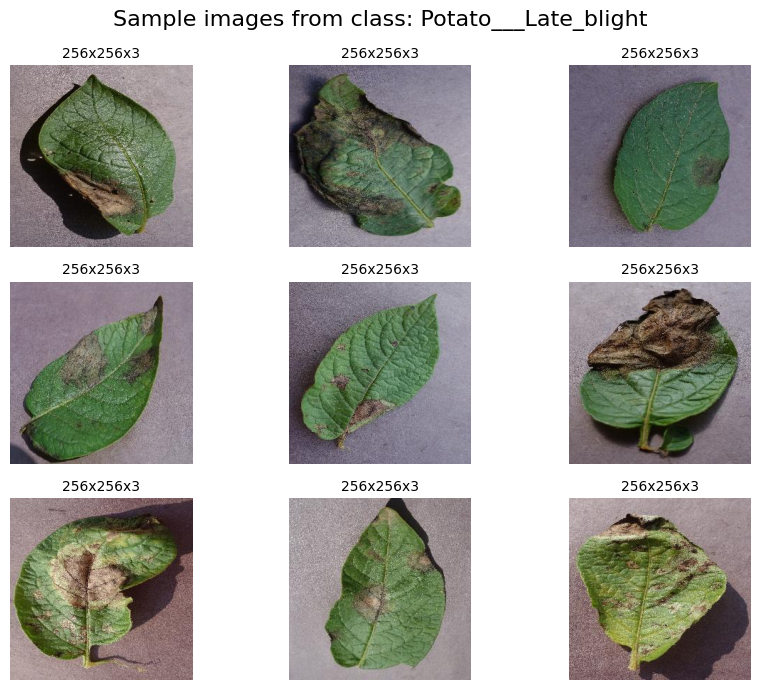

In [19]:
# Display some sample images from the raw data for visual inspection
sample_class = random.choice(categories)
sample_images = random.sample(os.listdir(os.path.join(data_path, sample_class)), 9)

fig, axs = plt.subplots(3, 3, figsize=(9, 7))
fig.suptitle(f"Sample images from class: {sample_class}", fontsize=16)

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(data_path, sample_class, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, c = img.shape
    axs[i // 3, i % 3].imshow(img)
    axs[i // 3, i % 3].set_title(f"{w}x{h}x{c}", fontsize=10)
    axs[i // 3, i % 3].axis('off')

    # Optional: print detailed info in console
    print(f"{img_name}: shape = {img.shape}")

plt.tight_layout()
plt.show()

### Step 5. Preparing Datasets to build CNN Models

In [22]:
training_set = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 12377 files belonging to 15 classes.


In [23]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 4122 files belonging to 15 classes.


In [24]:
cnn = tf.keras.models.Sequential()

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=[128, 128, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Dropout(0.20))
cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1500, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.4))

cnn.add(tf.keras.layers.Dense(units=15, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [26]:
cnn.compile(optimizer=tf.keras.optimizers.legacy.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
training_history = cnn.fit(x=training_set,validation_data=validation_set,epochs=10)

Epoch 1/10
387/387 [==============================] - 41s 83ms/step - loss: 2.8542 - accuracy: 0.5331 - val_loss: 0.7916 - val_accuracy: 0.7613
Epoch 2/10
387/387 [==============================] - 21s 53ms/step - loss: 0.7000 - accuracy: 0.7719 - val_loss: 0.4923 - val_accuracy: 0.8406
Epoch 3/10
387/387 [==============================] - 20s 53ms/step - loss: 0.4543 - accuracy: 0.8492 - val_loss: 0.4518 - val_accuracy: 0.8503
Epoch 4/10
387/387 [==============================] - 21s 54ms/step - loss: 0.3053 - accuracy: 0.8950 - val_loss: 0.3659 - val_accuracy: 0.8823
Epoch 5/10
387/387 [==============================] - 21s 54ms/step - loss: 0.2124 - accuracy: 0.9292 - val_loss: 0.4059 - val_accuracy: 0.8743
Epoch 6/10
387/387 [==============================] - 21s 54ms/step - loss: 0.1484 - accuracy: 0.9509 - val_loss: 0.3542 - val_accuracy: 0.8935
Epoch 7/10
387/387 [==============================] - 21s 53ms/step - loss: 0.1383 - accuracy: 0.9551 - val_loss: 0.3346 - val_accuracy:

### Step 6. Evaluation on Training & Validation Datasets

In [30]:
#Training set Accuracy
train_loss, train_acc = cnn.evaluate(training_set)
print('Training accuracy:', train_acc)
#Validation set Accuracy
val_loss, val_acc = cnn.evaluate(validation_set)
print('Validation accuracy:', val_acc)

387/387 [==============================] - 7s 17ms/step - loss: 0.0303 - accuracy: 0.9917
Training accuracy: 0.9916781187057495
129/129 [==============================] - 2s 17ms/step - loss: 0.3743 - accuracy: 0.8993
Validation accuracy: 0.8993207216262817


In [31]:
# Save the trained model
cnn.save('trained_plant_disease_model.keras')

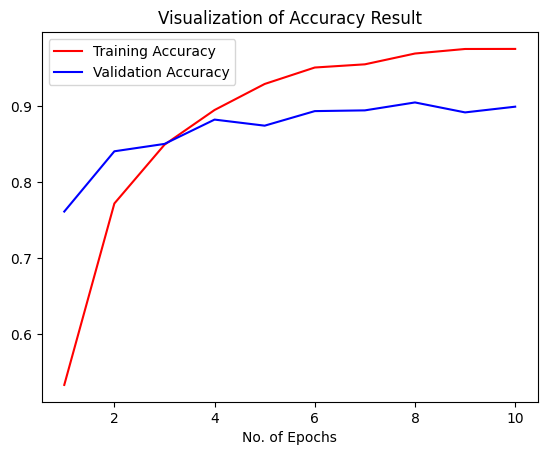

In [32]:
epochs = [i for i in range(1,11)]
plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [36]:
test_set = tf.keras.utils.image_dataset_from_directory(
    'test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 4139 files belonging to 15 classes.


In [39]:
y_pred = cnn.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)
Y_true
predicted_categories
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(Y_true,predicted_categories)
# Precision Recall Fscore
print(classification_report(Y_true,predicted_categories,target_names=class_name))

4139/4139 [==============================] - 12s 3ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.91      0.80      0.85       200
                     Pepper__bell___healthy       0.78      0.99      0.87       297
                      Potato___Early_blight       0.91      0.96      0.93       200
                       Potato___Late_blight       0.95      0.78      0.85       200
                           Potato___healthy       0.81      0.71      0.76        31
                      Tomato_Bacterial_spot       0.94      0.96      0.95       426
                        Tomato_Early_blight       0.85      0.75      0.80       200
                         Tomato_Late_blight       0.83      0.92      0.87       383
                           Tomato_Leaf_Mold       0.93      0.91      0.92       191
                  Tomato_Septoria_leaf_spot       0.95      0.83      0.89       355
Tomato

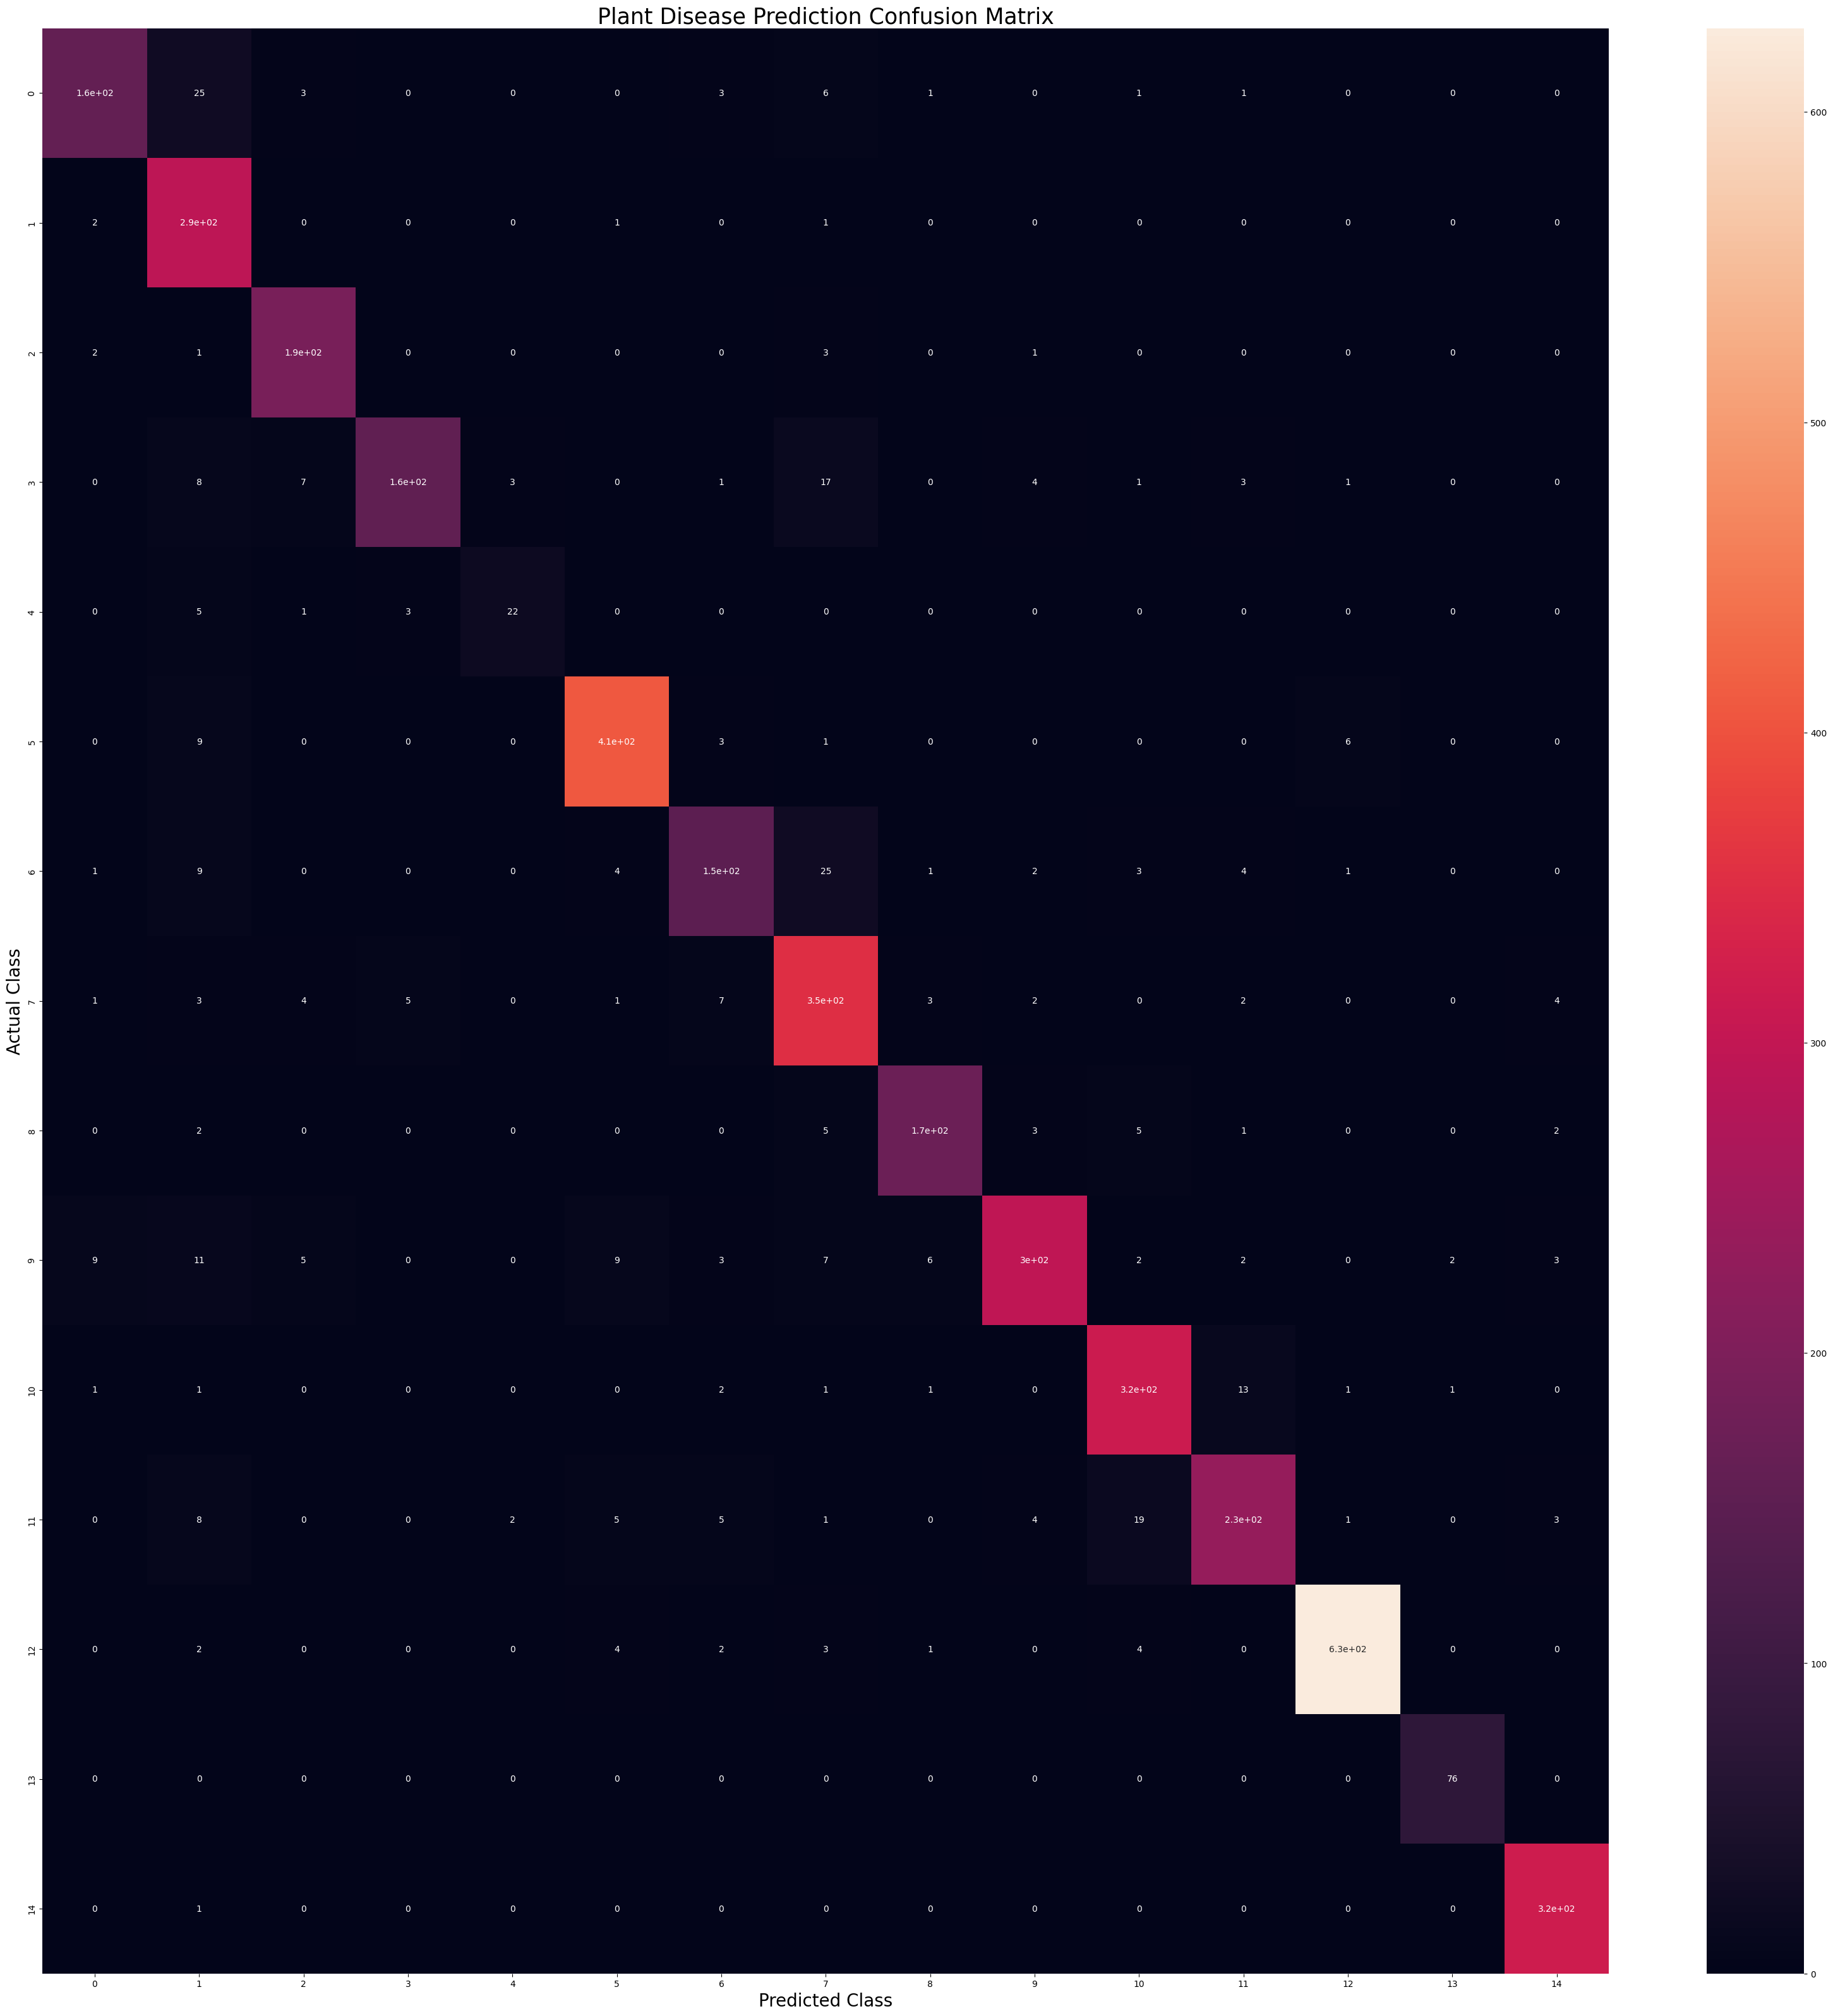

In [41]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})
plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()